<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/TGV_0105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda
--- Data Generation ---
Generated data at t=0.0
Generated data at t=1.0
Generated data at t=2.0

--- Training Start ---
Phase 1: Adam Optimization
[Adam] Epoch 0 | Total: 4.96821 | Data: 0.48501 | Phys: 0.11813
[Adam] Epoch 500 | Total: 0.73928 | Data: 0.02656 | Phys: 0.47366
[Adam] Epoch 1000 | Total: 0.52028 | Data: 0.01755 | Phys: 0.34481
[Adam] Epoch 1500 | Total: 0.45989 | Data: 0.01494 | Phys: 0.31045
[Adam] Epoch 2000 | Total: 0.42449 | Data: 0.01332 | Phys: 0.29133
[Adam] Epoch 2500 | Total: 0.39902 | Data: 0.01216 | Phys: 0.27741

Phase 2: L-BFGS Optimization (Fine-tuning)
Training Completed. Total Time: 40.83 min

--- Testing at t=1.5 (Unseen Time) ---


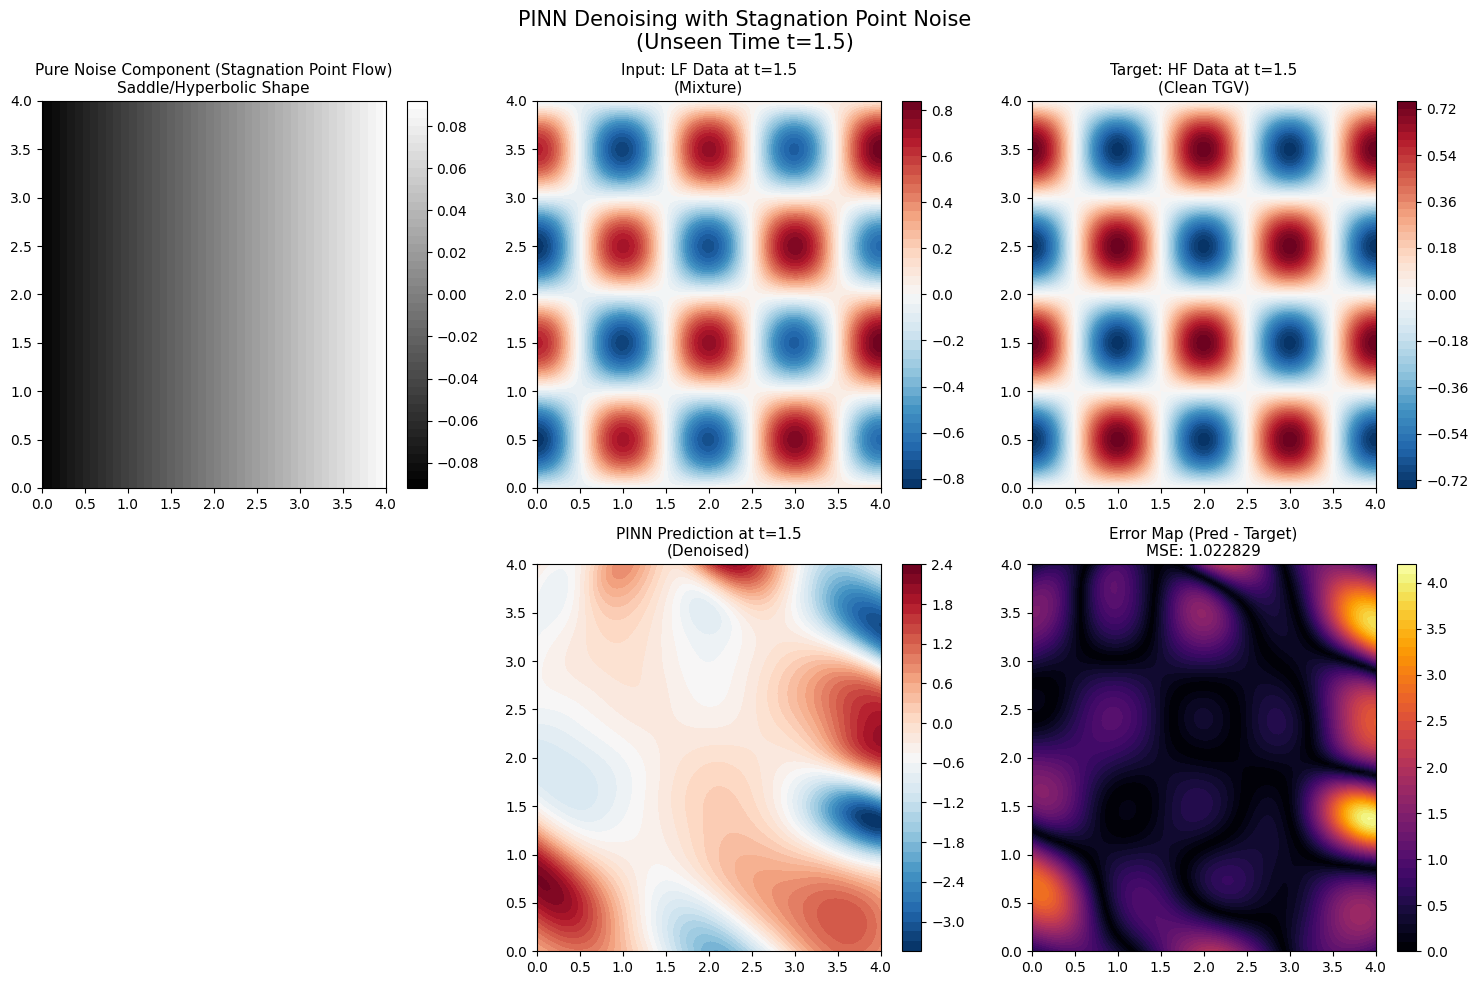

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 0. 환경 설정
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

np.random.seed(42)
torch.manual_seed(42)

# ==========================================
# 1. 유동장 데이터 생성 클래스 (Noise 변경됨)
# ==========================================
class FluidGenerator:
    def __init__(self, L=4.0, nu=0.01):
        self.L = L
        self.nu = nu

    def get_tgv_solution(self, X, Y, t):
        """
        [High Fidelity] Taylor-Green Vortex
        형태: 전형적인 격자형 소용돌이
        진폭: 1.0 (Dominant)
        """
        k = 1
        decay = np.exp(-2 * (k * np.pi)**2 * self.nu * t)

        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay

        # 압력
        p_decay = np.exp(-4 * (k * np.pi)**2 * self.nu * t)
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * p_decay

        return u, v, p

    def get_stagnation_point_noise(self, X, Y, t):
        """
        [Noise] Unsteady Stagnation Point Flow (비정상 정체점 유동)
        형태: 안장점(Saddle Point) 흐름.
             (2, 2)를 중심으로 유체가 들어왔다 나가는 쌍곡선 형태.
        물리: NS 방정식을 만족하는 Exact Solution.
             u = A * x * exp(-t), v = -A * y * exp(-t) 형태의 변형.
        """
        # 진폭 A=0.2 (Noise Level)
        A = 0.2
        # 감쇠율 (임의 설정 가능, 여기서는 nu와 무관하게 시간 t에 따라 감소하도록 설정)
        decay_rate = 1.0
        time_factor = np.exp(-decay_rate * t)

        # 도메인 중심 (2, 2)를 정체점(Stagnation Point)으로 설정
        xc, yc = 2.0, 2.0

        # 속도장 정의
        # u는 x방향으로 멀어질수록 커짐 (Outflow)
        # v는 y방향으로 멀어질수록 커지는데 방향은 중심을 향함 (Inflow)
        # Continuity Check: u_x + v_y = A*exp + (-A)*exp = 0 (만족)
        u =  A * (X - xc) * time_factor
        v = -A * (Y - yc) * time_factor

        # 압력장 (Pressure)
        # Navier-Stokes 식에 대입하여 역산출한 압력장
        # p = -0.5 * rho * (u^2 + v^2) + ... (Bernoulli-like terms + Unsteady terms)
        # 계산 결과: p = -0.5 * A^2 * exp(-2t) * (x^2 + y^2) - A * decay * exp(-t) * 0.5 * (x^2 - y^2) 등 복잡
        # 하지만 학습 데이터로 사용할 때는 해석해의 값만 있으면 되므로 수식으로 정의.

        # 단순화된 압력항 (Bernoulli 항과 비정상 항의 합)
        # P_x = ... 적분하여 구함
        term1 = 0.5 * A * (decay_rate + A * time_factor) * (X - xc)**2
        term2 = 0.5 * A * (decay_rate - A * time_factor) * (Y - yc)**2
        p = (term1 + term2) * time_factor

        return u, v, p

    def get_data_at_t(self, nx, ny, t_val):
        x = np.linspace(0, self.L, nx)
        y = np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)

        # 1. High Fidelity (TGV)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)

        # 2. Noise (Stagnation Point Flow) - 변경된 부분
        u_noise, v_noise, p_noise = self.get_stagnation_point_noise(X, Y, t_val)

        # 3. Low Fidelity = HF + Noise
        u_lf = u_hf + u_noise
        v_lf = v_hf + v_noise
        p_lf = p_hf + p_noise

        return X, Y, u_lf, v_lf, p_lf, u_hf, v_hf, p_hf

# ==========================================
# 2. 데이터셋 구성
# ==========================================
L_val = 4.0
nu_val = 0.01
GRID = 100
generator = FluidGenerator(L=L_val, nu=nu_val)

train_times = [0.0, 1.0, 2.0]

x_list, y_list, t_list = [], [], []
u_train_list, v_train_list, p_train_list = [], [], []

print("--- Data Generation ---")
for t in train_times:
    X, Y, u_l, v_l, p_l, _, _, _ = generator.get_data_at_t(GRID, GRID, t)

    x_list.append(X.flatten())
    y_list.append(Y.flatten())
    t_list.append(np.full(X.size, t))

    u_train_list.append(u_l.flatten())
    v_train_list.append(v_l.flatten())
    p_train_list.append(p_l.flatten())
    print(f"Generated data at t={t}")

x_train = torch.tensor(np.concatenate(x_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(np.concatenate(y_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(np.concatenate(t_list), dtype=torch.float32).view(-1, 1).to(device)

u_train_lf = torch.tensor(np.concatenate(u_train_list), dtype=torch.float32).view(-1, 1).to(device)
v_train_lf = torch.tensor(np.concatenate(v_train_list), dtype=torch.float32).view(-1, 1).to(device)
p_train_lf = torch.tensor(np.concatenate(p_train_list), dtype=torch.float32).view(-1, 1).to(device)

# Physics Collocation Points
N_phys = 30000
x_phys = torch.rand(N_phys, 1).to(device).requires_grad_(True)
y_phys = torch.rand(N_phys, 1).to(device).requires_grad_(True)
t_phys = (torch.rand(N_phys, 1) * 2.5).to(device).requires_grad_(True)

# ==========================================
# 3. PINN 모델 정의
# ==========================================
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super().__init__()
        self.register_buffer("B", torch.randn(in_channels, 128) * scale)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Fourier Scale 1.5: 저주파(HF) 학습 우선
        self.embedding = FourierEmbedding(in_channels=3, scale=1.5)

        self.net = nn.Sequential(
            nn.Linear(256, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 3)
        )

    def forward(self, x, y, t):
        cat_input = torch.cat([x, y, t], dim=1)
        emb = self.embedding(cat_input)
        return self.net(emb)

# ==========================================
# 4. Physics Loss (NS Equation)
# ==========================================
def get_pde_loss(model, x, y, t, nu):
    out = model(x, y, t)
    u, v, p = out[:, 0:1], out[:, 1:2], out[:, 2:3]

    # Gradients
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    # NS Residuals
    f_mass = u_x + v_y
    f_u = u_t + (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)
    f_v = v_t + (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)

    return torch.mean(f_mass**2) + torch.mean(f_u**2) + torch.mean(f_v**2)

# ==========================================
# 5. 학습 루프 (Adam + L-BFGS 하이브리드)
# ==========================================
model = PINN().to(device)

# 1단계: Adam (빠른 수렴, 전역 탐색)
optimizer_adam = optim.Adam(model.parameters(), lr=1e-4)

# 2단계: L-BFGS (정밀 수렴)
# history_size: 메모리 저장량, max_iter: 최대 반복 횟수
optimizer_lbfgs = optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=5000,
    max_eval=5000,
    history_size=50,
    tolerance_grad=1e-7,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe" # 중요: 안정적인 수렴을 위해 필수
)

start_time = time.time()
print("\n--- Training Start ---")

# ---------------------------------------
# Phase 1: Adam Optimizer
# ---------------------------------------
print("Phase 1: Adam Optimization")
for epoch in range(2501):
    optimizer_adam.zero_grad()

    # Prediction
    out_pred = model(x_train, y_train, t_train)
    u_pred, v_pred, p_pred = out_pred[:,0:1], out_pred[:,1:2], out_pred[:,2:3]

    # Loss 1: Data Loss (LF 데이터)
    loss_data = torch.mean((u_pred - u_train_lf)**2 +
                           (v_pred - v_train_lf)**2 +
                           (p_pred - p_train_lf)**2)

    # Loss 2: Physics Loss (NS 방정식)
    loss_phys = get_pde_loss(model, x_phys, y_phys, t_phys, nu_val)

    # Total Loss (가중치 적용)
    loss = 10.0 * loss_data + 1.0 * loss_phys

    loss.backward()
    optimizer_adam.step()

    if epoch % 500 == 0:
        print(f"[Adam] Epoch {epoch} | Total: {loss.item():.5f} | Data: {loss_data.item():.5f} | Phys: {loss_phys.item():.5f}")

# ---------------------------------------
# Phase 2: L-BFGS Optimizer
# ---------------------------------------
print("\nPhase 2: L-BFGS Optimization (Fine-tuning)")

def closure():
    optimizer_lbfgs.zero_grad()

    out_pred = model(x_train, y_train, t_train)
    u_pred, v_pred, p_pred = out_pred[:,0:1], out_pred[:,1:2], out_pred[:,2:3]

    loss_data = torch.mean((u_pred - u_train_lf)**2 +
                           (v_pred - v_train_lf)**2 +
                           (p_pred - p_train_lf)**2)

    loss_phys = get_pde_loss(model, x_phys, y_phys, t_phys, nu_val)

    loss = 10.0 * loss_data + 1.0 * loss_phys

    loss.backward()
    return loss

# L-BFGS 실행
optimizer_lbfgs.step(closure)

print(f"Training Completed. Total Time: {(time.time()-start_time)/60:.2f} min")
# ==========================================
# 6. 예측 및 시각화 (Unseen Time t=1.5)
# ==========================================
test_t = 1.5
print(f"\n--- Testing at t={test_t} (Unseen Time) ---")

X_grid, Y_grid, u_lf_truth, v_lf_truth, _, u_hf_truth, v_hf_truth, _ = generator.get_data_at_t(GRID, GRID, test_t)

x_test = torch.tensor(X_grid.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_test = torch.tensor(Y_grid.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_test = torch.tensor(np.full(x_test.shape, test_t), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    out_test = model(x_test, y_test, t_test)
    u_pred_grid = out_test[:, 0].cpu().numpy().reshape(GRID, GRID)

# --- 시각화 ---
plt.figure(figsize=(15, 10))

# 1. Noise Pattern 확인
u_noise_only = u_lf_truth - u_hf_truth
plt.subplot(2, 3, 1)
plt.contourf(X_grid, Y_grid, u_noise_only, levels=50, cmap='gray')
plt.title(f"Pure Noise Component (Stagnation Point Flow)\nSaddle/Hyperbolic Shape", fontsize=11)
plt.colorbar()

# 2. Input LF (HF + Noise)
plt.subplot(2, 3, 2)
plt.contourf(X_grid, Y_grid, u_lf_truth, levels=50, cmap='RdBu_r')
plt.title(f"Input: LF Data at t={test_t}\n(Mixture)", fontsize=11)
plt.colorbar()

# 3. Ground Truth HF (Target)
plt.subplot(2, 3, 3)
plt.contourf(X_grid, Y_grid, u_hf_truth, levels=50, cmap='RdBu_r')
plt.title(f"Target: HF Data at t={test_t}\n(Clean TGV)", fontsize=11)
plt.colorbar()

# 4. PINN Prediction (Reconstructed)
plt.subplot(2, 3, 5)
plt.contourf(X_grid, Y_grid, u_pred_grid, levels=50, cmap='RdBu_r')
plt.title(f"PINN Prediction at t={test_t}\n(Denoised)", fontsize=11)
plt.colorbar()

# 5. Error Map (Pred vs HF)
err = np.abs(u_pred_grid - u_hf_truth)
plt.subplot(2, 3, 6)
plt.contourf(X_grid, Y_grid, err, levels=50, cmap='inferno')
plt.title(f"Error Map (Pred - Target)\nMSE: {np.mean(err**2):.6f}", fontsize=11)
plt.colorbar()

plt.suptitle(f"PINN Denoising with Stagnation Point Noise\n(Unseen Time t={test_t})", fontsize=15)
plt.tight_layout()
plt.show()